In [25]:
import os
import pandas as pd
import numpy as np
from scipy.stats import norm
from MCMC_normalX import MCMC_normalX
from MCMC_fixedS import MCMC_fixedS
from bayes_fixedS_fast import bayes_fixedS_fast
from adassp import adassp
from closest_psd import closest_psd
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [26]:
def load_data(dataset):
    data_path = os.path.join("data", dataset)
    # read csv file without column names
    df = pd.read_csv(data_path, header=None)
    if dataset == "air_quality.csv":
        # remove last 2 columns
        df = df.iloc[:, :-2]
        df = df.dropna()
        X = df.iloc[:, :-1]
        y = df.iloc[:, -1]
    else:
        X = df.iloc[:, :-1]
        y = df.iloc[:, -1]
    X = X.to_numpy()
    y = y.to_numpy()
    X = StandardScaler().fit_transform(X)
    y = y - np.mean(y)
    y = y / np.max(np.abs(y))
    return X, y

In [27]:
dataset_list = ["air_quality.csv", "3droad.csv", "bike_sharing.csv", "power_plant_energy.csv"]
dataset = dataset_list[-1]
X, y = load_data(dataset)
d = X.shape[1]
n = X.shape[0]
X.shape, y.shape

((9568, 4), (9568,))

In [28]:
# Split the data into training and test sets
test_ratio = 0.2  # Test data ratio
n_train = int(np.ceil(n * (1 - test_ratio)))  # Number of data points for training

# Training data
X_train = X[:n_train, :]
y_train = y[:n_train]

# Test data
X_test = X[n_train:, :]
y_test = y[n_train:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7655, 4), (7655,), (1913, 4), (1913,))

In [29]:
model = LinearRegression()
model.fit(X_train, y_train)
theta_true = model.coef_
# theta_true = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ y_train

theta_true

array([-0.35861513, -0.06973807,  0.00887603, -0.05662627])

In [30]:
def analytic_Gaussian_mech(epsilon, delta):
    delta_0 = norm.cdf(0) - np.exp(epsilon) * norm.cdf(-2 * np.sqrt(epsilon))
    if delta >= delta_0:
        v_max = 0
        c = 0
        while c == 0:
            v = np.arange(v_max, v_max + 1.001, 0.001)
            v_max += 1
            B = norm.cdf(np.sqrt(epsilon) * v) - np.exp(epsilon) * norm.cdf(-np.sqrt(epsilon * (v + 2)))
            c = (np.max(B) > delta) * (np.min(B) < delta)
        v_sol = v[np.sum(B <= delta)]
        alpha = np.sqrt(1 + v_sol / 2) - np.sqrt(v_sol / 2)
    else:
        u_max = 0
        c = 0
        while c == 0:
            u = np.arange(u_max, u_max + 1.001, 0.001)
            u_max += 1
            B = norm.cdf(-np.sqrt(epsilon) * u) - np.exp(epsilon) * norm.cdf(-np.sqrt(epsilon * (u + 2)))
            c = (np.min(B) < delta) * (np.max(B) > delta)
        u_sol = u[np.sum(B > delta) + 1]
        alpha = np.sqrt(1 + u_sol / 2) + np.sqrt(u_sol / 2)
    sigma = alpha / np.sqrt(2 * epsilon)
    return sigma

In [51]:
# Determine bound_X and bound_Y
bound_X = np.max(np.linalg.norm(X_train, axis=1))
bound_y = np.max(np.abs(y_train))
bound_SZ = np.sqrt(bound_X**4 + (bound_X*bound_y)**2)

# Print the results
print("bound_X:", bound_X)
print("bound_Y:", bound_y)
# print("bound_SS:", bound_SS)
print("bound_SZ:", bound_SZ)

bound_X: 4.166854626048434
bound_Y: 1.0
bound_SZ: 17.85567827225673


In [32]:
epsilon = 1
delta = 1/n_train

sigma_unit1 = analytic_Gaussian_mech(epsilon, delta)
sigma_unit2 = analytic_Gaussian_mech(epsilon/2, delta/2)

# std_SS = sigma_unit1*bound_SS
std_SZ = sigma_unit1*bound_SZ
std_S1 = sigma_unit2*bound_X**2
std_Z1 = sigma_unit2*bound_X*bound_y
        
if std_S1**2 + std_Z1**2 > std_SZ**2:
    std_S = std_SZ
    std_z = std_SZ
else:
    std_S = std_S1
    std_z = std_Z1

In [33]:
def divide_dataset(X, y, J):
    # Split X and y arrays into J subsets
    X_subsets = np.array_split(X, J)
    y_subsets = np.array_split(y, J)
    
    return X_subsets, y_subsets

In [34]:
J = 5
X_subsets, y_subsets = divide_dataset(X_train, y_train, J)
N_node = [X_subsets[j].shape[0] for j in range(J)]
for j in range(J):
    print(f"Node {j+1} - X: {X_subsets[j].shape} y: {y_subsets[j].shape}")

Node 1 - X: (1531, 4) y: (1531,)
Node 2 - X: (1531, 4) y: (1531,)
Node 3 - X: (1531, 4) y: (1531,)
Node 4 - X: (1531, 4) y: (1531,)
Node 5 - X: (1531, 4) y: (1531,)


In [35]:
def noisy_statistics(X_subsets, y_subsets, J, std_S, std_z):
    S = []
    z = []
    d = X_subsets[0].shape[1]
    for j in range(J):
        # generate a random symmetric matrix M_j
        upper_triangular = np.random.normal(0, 1, size=(d, d))
        M_j = np.triu(upper_triangular) + np.triu(upper_triangular, 1).T
        # generate a random vector v_j
        v_j = np.random.normal(0, 1, size=d)

        # compute the noisy statistics
        S.append(np.dot(X_subsets[j].T, X_subsets[j]) + std_S * M_j)
        z.append(np.dot(X_subsets[j].T, y_subsets[j]) + std_z * v_j)
    
    return S, z

In [36]:
S_obs, z_obs = noisy_statistics(X_subsets, y_subsets, J, std_S, std_z)
for j in range(J):
    print(f"Node {j+1} - S: {S_obs[j].shape} z: {z_obs[j].shape}")

Node 1 - S: (4, 4) z: (4,)
Node 2 - S: (4, 4) z: (4,)
Node 3 - S: (4, 4) z: (4,)
Node 4 - S: (4, 4) z: (4,)
Node 5 - S: (4, 4) z: (4,)


In [37]:
K = 10000
a0 = 20
b0 = 0.5

# hyperparameters
hyperparameters = {"m": np.zeros(d), "C": (a0-1)/b0 * np.eye(d), "a": a0, "b": b0, "var_S": std_S**2, "var_Z": std_z**2, "Lambda" : b0/(a0-1) * np.eye(d), "kappa" : d + 1}

# proposal parameters
prop_params = {"sigma_q_y": 0.1, "a_MH": [10**(2*(np.log10(N_node[j])-1)) for j in range(J)]}

S0 = []
for j in range(J):
    S0.append(closest_psd(S_obs[j]) + np.eye(d))

# initial variables
init_vars = {"theta" : np.zeros(d), "var_y" : bound_y/3, "S": S0}

DP_parameters = {"bound_y": bound_y}

outputs_MCMC_normalX = MCMC_normalX(S_obs, z_obs, init_vars, hyperparameters, prop_params, N_node, K)
theta_hat_MCMC_normalX = outputs_MCMC_normalX["theta_vec"][:, -1]

outputs_MCMC_fixedS = MCMC_fixedS(z_obs, init_vars, hyperparameters, prop_params, N_node, K)
theta_hat_MCMC_fixedS = outputs_MCMC_fixedS["theta_vec"][:, -1]

mu_theta, cov_theta = bayes_fixedS_fast(S_obs, z_obs, DP_parameters, hyperparameters)

print("theta true:", theta_true)
print("MCMC_normalX:", theta_hat_MCMC_normalX)
print("MCMC_fixedS:", theta_hat_MCMC_fixedS)
print("bayes_fixedS_fast:", mu_theta)

theta true: [-0.35861513 -0.06973807  0.00887603 -0.05662627]
MCMC_normalX: [-0.36693253 -0.07383291  0.0178029  -0.06324455]
MCMC_fixedS: [-0.36600402 -0.08943079  0.01248406 -0.07399968]
bayes_fixedS_fast: [-0.15508667 -1.01378086  0.36802777  0.04670569]


In [39]:
y_pred = np.dot(X_test, theta_true)
y_pred_MCMC_normalX = np.dot(X_test, theta_hat_MCMC_normalX)
y_pred_MCMC_fixedS = np.dot(X_test, theta_hat_MCMC_fixedS)
y_pred_bayes_fixedS = np.dot(X_test, mu_theta)

print("MSE_true:", mean_squared_error(y_test, y_pred))
print("MSE_MCMC_normalX:", mean_squared_error(y_test, y_pred_MCMC_normalX))
print("MSE_MCMC_fixedS:", mean_squared_error(y_test, y_pred_MCMC_fixedS))
print("MSE_bayes_fixedS_fast:", mean_squared_error(y_test, y_pred_bayes_fixedS))

MSE_true: 0.012685196328902547
MSE_MCMC_normalX: 0.013024616686068777
MSE_MCMC_fixedS: 0.01341039895066622
MSE_bayes_fixedS_fast: 1.0030937252150374


## **Experiments**

In [83]:
def trial(epsilon, J):
    """
    Conducts a trial experiment with different epsilon and J values.

    Parameters:
        epsilon (float): Privacy parameter epsilon.
        J (int): Number of subsets.

    Returns:
        tuple: A tuple containing the following:
            - outputs_MCMC_normalX (dict): Output dictionary for MCMC with normalX method.
            - theta_hat_MCMC_normalX (array): Estimated parameters from MCMC with normalX method.
            - outputs_MCMC_fixedS (dict): Output dictionary for MCMC with fixedS method.
            - theta_hat_MCMC_fixedS (array): Estimated parameters from MCMC with fixedS method.
    """

    # Privacy parameter delta
    delta = 1 / n_train

    # Compute noise levels
    sigma_unit1 = analytic_Gaussian_mech(epsilon, delta)
    sigma_unit2 = analytic_Gaussian_mech(epsilon/2, delta/2)

    # Compute standard deviations
    std_SZ = sigma_unit1 * bound_SZ
    std_S1 = sigma_unit2 * bound_X**2
    std_Z1 = sigma_unit2 * bound_X * bound_y
            
    if std_S1**2 + std_Z1**2 > std_SZ**2:
        std_S = std_SZ
        std_z = std_SZ
    else:
        std_S = std_S1
        std_z = std_Z1

    # Divide dataset into subsets
    X_subsets, y_subsets = divide_dataset(X_train, y_train, J)
    N_node = [X_subsets[j].shape[0] for j in range(J)]

    # Compute noisy statistics
    S_obs, z_obs = noisy_statistics(X_subsets, y_subsets, J, std_S, std_z)

    # Set constants
    K = 10000
    a0 = 20
    b0 = 0.5

    # Hyperparameters
    hyperparameters = {"m": np.zeros(d), "C": (a0-1)/b0 * np.eye(d), "a": a0, "b": b0, "var_S": std_S**2, "var_Z": std_z**2, "Lambda" : b0/(a0-1) * np.eye(d), "kappa" : d + 1}

    # Proposal parameters
    prop_params = {"sigma_q_y": 0.1, "a_MH": [10**(2*(np.log10(N_node[j])-1)) for j in range(J)]}

    # Initial S values
    S0 = [closest_psd(S_obs[j]) + np.eye(d) for j in range(J)]

    # Initial variables
    init_vars = {"theta" : np.zeros(d), "var_y" : bound_y/3, "S": S0}

    # Run MCMC with normalX method
    outputs_MCMC_normalX = MCMC_normalX(S_obs, z_obs, init_vars, hyperparameters, prop_params, N_node, K)
    theta_hat_MCMC_normalX = outputs_MCMC_normalX["theta_vec"][:, -1]

    # Run MCMC with fixedS method
    outputs_MCMC_fixedS = MCMC_fixedS(z_obs, init_vars, hyperparameters, prop_params, N_node, K)
    theta_hat_MCMC_fixedS = outputs_MCMC_fixedS["theta_vec"][:, -1]

    # Run Bayes fixedS fast method
    mu_theta, cov_theta = bayes_fixedS_fast(S_obs, z_obs, DP_parameters, hyperparameters)

    return outputs_MCMC_normalX, theta_hat_MCMC_normalX, outputs_MCMC_fixedS, theta_hat_MCMC_fixedS, mu_theta


In [81]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

# Set seaborn style
sns.set(style="whitegrid")

# Define parameters
epsilon_values = [0.1, 0.2, 0.5, 1, 2, 5, 10]
J_values = [1, 5, 10]

# Define a function to calculate log_mse
def log_mse(x, y):
    return np.log(mean_squared_error(x,y))

# Function to run trials
def run_trials(epsilon_values, J_values):
    results = {}
    for J in J_values:
        results[J] = {"normalX": [], "fixedS": [], "fastBayes_fixedS": [], "theta_normalX": [], "theta_fixedS": [], "theta_fastBayes_fixedS": [], "OLS": []}
        for epsilon in epsilon_values:
            output_normalX, theta_normalX, output_fixedS, theta_fixedS, theta_fbfixedS = trial(epsilon, J)
            results[J]["normalX"].append(output_normalX)
            results[J]["fixedS"].append(output_fixedS)
            results[J]["theta_normalX"].append(theta_normalX)
            results[J]["theta_fixedS"].append(theta_fixedS)
            results[J]["theta_fastBayes_fixedS"].append(theta_fbfixedS)
    return results


# Run trials and plot results
results = run_trials(epsilon_values, J_values)

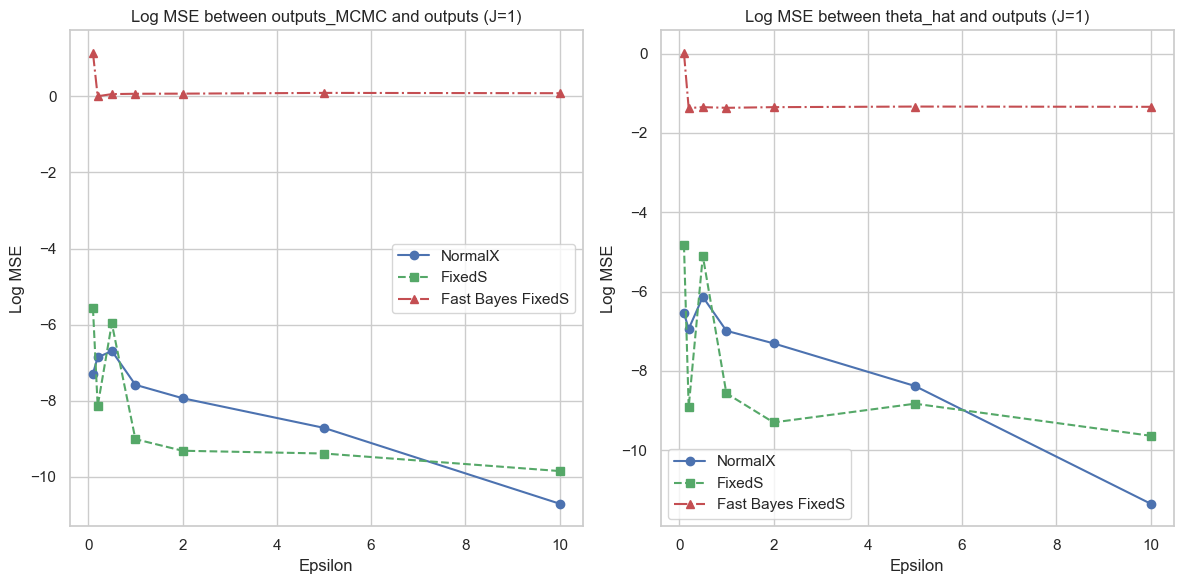

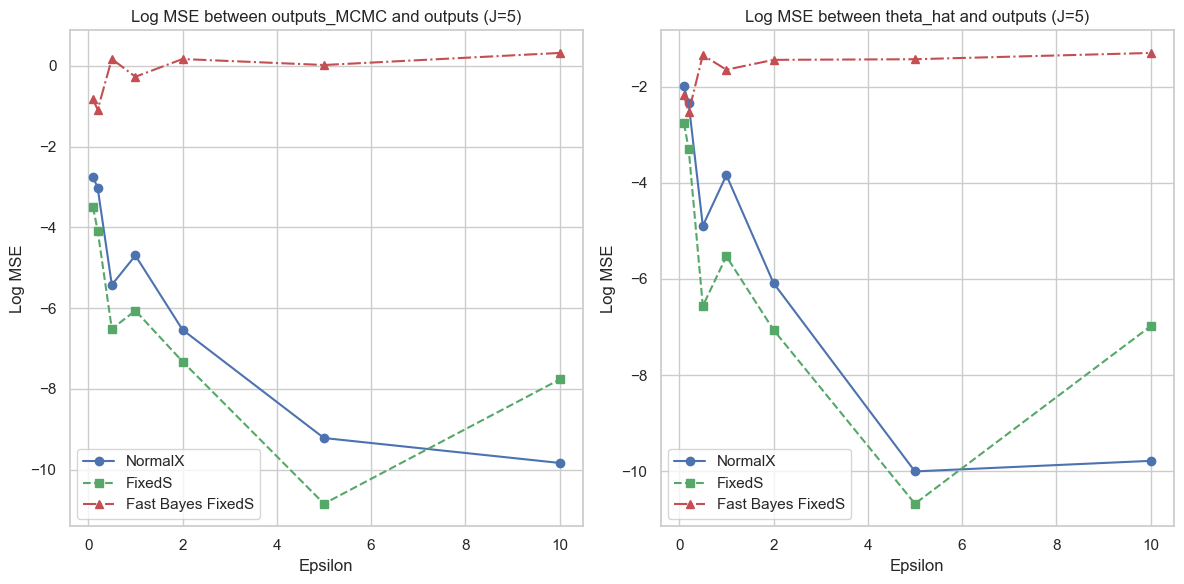

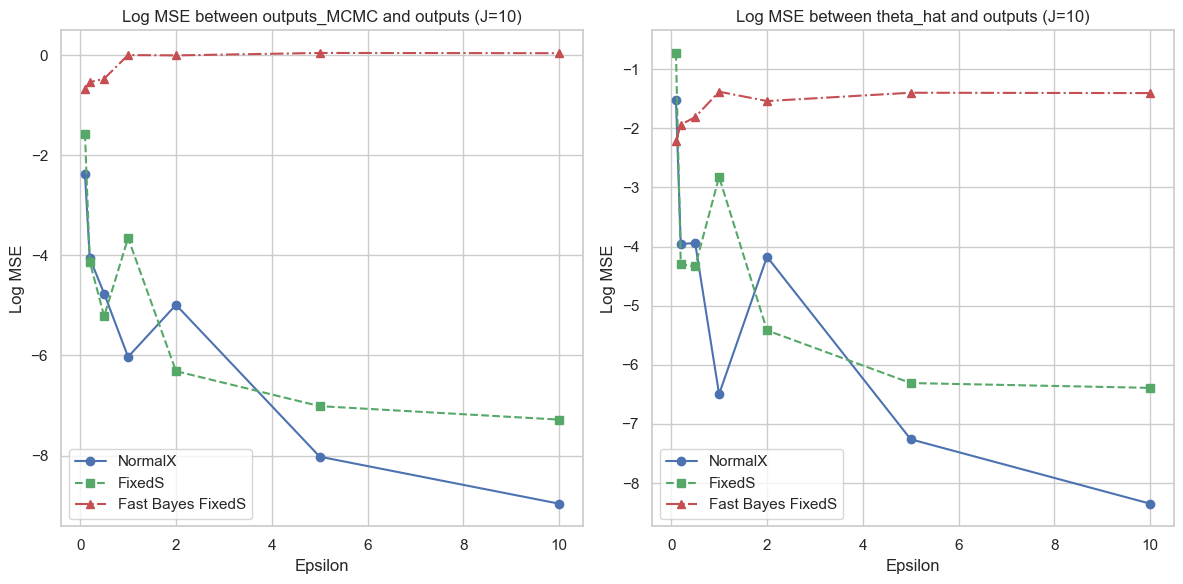

In [47]:
def plot_results(results, epsilon_values):
    for J in results.keys():
        normalX_mse = [log_mse(y_pred, np.dot(X_test, output["theta_vec"][:, -1])) for output in results[J]["normalX"]]
        fixedS_mse = [log_mse(y_pred, np.dot(X_test, output["theta_vec"][:, -1])) for output in results[J]["fixedS"]]
        fastbayes_fixedS_mse = [log_mse(y_pred, np.dot(X_test, output)) for output in results[J]["theta_fastBayes_fixedS"]]
        theta_normalX_mse = [log_mse(theta_true, output) for output in results[J]["theta_normalX"]]
        theta_fixedS_mse = [log_mse(theta_true, output) for output in results[J]["theta_fixedS"]]
        fastbayes_theta_fixedS_mse = [log_mse(theta_true, output) for output in results[J]["theta_fastBayes_fixedS"]]

        plt.figure(figsize=(12, 6))  # Increase figure size for better readability

        plt.subplot(1, 2, 1)
        plt.plot(epsilon_values, normalX_mse, label="NormalX", marker='o', linestyle='-', color='b')
        plt.plot(epsilon_values, fixedS_mse, label="FixedS", marker='s', linestyle='--', color='g')
        plt.plot(epsilon_values, fastbayes_fixedS_mse, label="Fast Bayes FixedS", marker='^', linestyle='-.', color='r')
        plt.xlabel('Epsilon')
        plt.ylabel('Log MSE')
        plt.title(f'Log MSE between outputs_MCMC and outputs (J={J})')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epsilon_values, theta_normalX_mse, label="NormalX", marker='o', linestyle='-', color='b')
        plt.plot(epsilon_values, theta_fixedS_mse, label="FixedS", marker='s', linestyle='--', color='g')
        plt.plot(epsilon_values, fastbayes_theta_fixedS_mse, label="Fast Bayes FixedS", marker='^', linestyle='-.', color='r')
        plt.xlabel('Epsilon')
        plt.ylabel('Log MSE')
        plt.title(f'Log MSE between theta_hat and outputs (J={J})')
        plt.legend()

        plt.tight_layout()  # Adjust subplot spacing
        plt.show()

plot_results(results, epsilon_values)


## **Experiments with the other noise**

In [137]:
def laplacian_noisy_statistics(X_subsets, y_subsets, J, std_S, std_z):
    S = []
    z = []
    d = X_subsets[0].shape[1]
    for j in range(J):
        # generate a random symmetric matrix M_j
        upper_triangular = np.random.laplace(0, 1, size=(d, d))
        M_j = np.triu(upper_triangular) + np.triu(upper_triangular, 1).T
        # generate a random vector v_j
        v_j = np.random.laplace(0, 1, size=d)

        # compute the noisy statistics
        S.append(np.dot(X_subsets[j].T, X_subsets[j]) + std_S * M_j)
        z.append(np.dot(X_subsets[j].T, y_subsets[j]) + std_z * v_j)
    
    return S, z

In [138]:
# Compute noisy statistics
S_obs_lap, z_obs_lap = laplacian_noisy_statistics(X_subsets, y_subsets, J, std_S, std_z)

# Set constants
K = 10000
a0 = 20
b0 = 0.5

# Hyperparameters
hyperparameters = {"m": np.zeros(d), "C": (a0-1)/b0 * np.eye(d), "a": a0, "b": b0, "var_S": std_S**2, "var_Z": std_z**2, "Lambda" : b0/(a0-1) * np.eye(d), "kappa" : d + 1}

# Proposal parameters
prop_params = {"sigma_q_y": 0.1, "a_MH": [10**(2*(np.log10(N_node[j])-1)) for j in range(J)]}

# Initial S values
S0 = [closest_psd(S_obs_lap[j]) + np.eye(d) for j in range(J)]

# Initial variables
init_vars = {"theta" : np.zeros(d), "var_y" : bound_y/3, "S": S0}

# Run MCMC with normalX method
outputs_MCMC_normalX = MCMC_normalX(S_obs_lap, z_obs_lap, init_vars, hyperparameters, prop_params, N_node, K)
theta_hat_MCMC_normalX = outputs_MCMC_normalX["theta_vec"][:, -1]

# Run MCMC with fixedS method
outputs_MCMC_fixedS = MCMC_fixedS(z_obs_lap, init_vars, hyperparameters, prop_params, N_node, K)
theta_hat_MCMC_fixedS = outputs_MCMC_fixedS["theta_vec"][:, -1]

# Run Bayes fixedS fast method
mu_theta, cov_theta = bayes_fixedS_fast(S_obs_lap, z_obs_lap, DP_parameters, hyperparameters)

print("theta true:", theta_true)
print("MCMC_normalX:", theta_hat_MCMC_normalX)
print("MCMC_fixedS:", theta_hat_MCMC_fixedS)
print("bayes_fixedS_fast:", mu_theta)

y_pred = np.dot(X_test, theta_true)
y_pred_MCMC_normalX = np.dot(X_test, theta_hat_MCMC_normalX)
y_pred_MCMC_fixedS = np.dot(X_test, theta_hat_MCMC_fixedS)
y_pred_bayes_fixedS = np.dot(X_test, mu_theta)

print("MSE_true:", mean_squared_error(y_test, y_pred))
print("MSE_MCMC_normalX:", mean_squared_error(y_test, y_pred_MCMC_normalX))
print("MSE_MCMC_fixedS:", mean_squared_error(y_test, y_pred_MCMC_fixedS))
print("MSE_bayes_fixedS_fast:", mean_squared_error(y_test, y_pred_bayes_fixedS))

theta true: [-0.35861513 -0.06973807  0.00887603 -0.05662627]
MCMC_normalX: [-0.05377661 -0.24436808  0.13652248  0.02873453]
MCMC_fixedS: [ 0.15888036 -0.38872703  0.152288    0.13705883]
bayes_fixedS_fast: [-0.24691824 -0.69396658  0.38604436  0.14143072]
MSE_true: 0.012685196328902547
MSE_MCMC_normalX: 0.030650538699407138
MSE_MCMC_fixedS: 0.05667191108393944
MSE_bayes_fixedS_fast: 0.6956426341991342


## **Experimental Trial: Adaptive epsilon**

In [69]:
import numpy as np
from scipy.special import kl_div


def calculate_informativeness(posterior_samples):
  """
  Example function to calculate informativeness based on posterior variance.

  Args:
      posterior_samples: A NumPy array containing MCMC samples from the posterior distribution.

  Returns:
      informativeness_score: A float representing the informativeness score.
  """
  variance = np.var(posterior_samples, axis=0).sum()
  informativeness_score = variance
  return informativeness_score

def calculate_redundancy_matrix(posterior_samples_list):
  """
  Example function to calculate pairwise KL divergence as a redundancy measure.

  Args:
      posterior_samples_list: List of posterior samples (one per client).

  Returns:
      redundancy_matrix: A NumPy library representing pairwise redundancy scores.
  """

  num_clients = len(posterior_samples_list)
  redundancy_matrix = np.zeros((num_clients, num_clients))
  for i in range(num_clients):
    for j in range(i + 1, num_clients):
      samples_i, samples_j = posterior_samples_list[i], posterior_samples_list[j]
      # Calculate KL divergence (replace with your chosen redundancy measure)
      redundancy_matrix[i, j] = kl_div(samples_i, samples_j).mean()
      redundancy_matrix[j, i] = redundancy_matrix[i, j]  # Symmetric matrix
  return redundancy_matrix

def select_top_clients(informativeness_scores, redundancy_matrix, budget_fraction):
  """
  Selects informative and non-redundant clients based on scores and budget.

  Args:
      informativeness_scores: List of informativeness scores for each client.
      redundancy_matrix: NumPy array representing pairwise redundancy scores.
      budget_fraction: Fraction of remaining budget to allocate to selected clients.

  Returns:
      selected_clients: List of indices of selected clients.
  """

  # Combine informativeness and redundancy scores (weighted average or other strategy)
  combined_scores = informativeness_scores - redundancy_matrix.sum(axis=1)
  num_clients = len(combined_scores)
  num_selected = int(budget_fraction * num_clients)
  # Select top clients based on combined scores
  selected_clients = np.argsort(combined_scores)[-num_selected:]
  return selected_clients.tolist()

In [70]:
def allocate_budget(epsilon_total, base_epsilon, selected_clients):
  """
  Allocates remaining privacy budget to selected clients.

  Args:
      epsilon_total: Total privacy budget.
      base_epsilon: Base epsilon allocated in the first round.
      selected_clients: List of indices of selected clients.

  Returns:
      epsilon_allocations: Dictionary mapping client indices to allocated epsilon values.
  """

  remaining_budget = epsilon_total - base_epsilon * len(selected_clients)
  num_selected = len(selected_clients)

  # Ensure remaining budget is enough for equal allocation (base_epsilon each)
  if remaining_budget < base_epsilon * num_selected:
    raise ValueError("Remaining budget is insufficient for selected clients.")

  epsilon_allocations = {i: base_epsilon + remaining_budget / num_selected for i in selected_clients}

  return epsilon_allocations

In [71]:
def get_subsets(epsilon, X_train, y_train):

  delta = 1/n_train

  sigma_unit1 = analytic_Gaussian_mech(epsilon, delta)
  sigma_unit2 = analytic_Gaussian_mech(epsilon/2, delta/2)

  # std_SS = sigma_unit1*bound_SS
  std_SZ = sigma_unit1*bound_SZ
  std_S1 = sigma_unit2*bound_X**2
  std_Z1 = sigma_unit2*bound_X*bound_y
          
  if std_S1**2 + std_Z1**2 > std_SZ**2:
      std_S = std_SZ
      std_z = std_SZ
  else:
      std_S = std_S1
      std_z = std_Z1

  J = 5
  X_subsets, y_subsets = divide_dataset(X_train, y_train, J)

  return X_subsets, y_subsets, std_S, std_z

In [72]:
def generate_hyperparameters(i, std_S, std_z):

  # hyperparameters
  hyperparameters = {"m": np.zeros(d), "C": (a0-1)/b0 * np.eye(d), "a": a0, "b": b0, "var_S": std_S**2, "var_Z": std_z**2, "Lambda" : b0/(a0-1) * np.eye(d), "kappa" : d + 1}

  # proposal parameters
  prop_params = {"sigma_q_y": 0.1, "a_MH": [10**(2*(np.log10(N_node[i])-1))]}

  S0 = [closest_psd(S_obs[j]) + np.eye(d)]

  # initial variables
  init_vars = {"theta" : np.zeros(d), "var_y" : bound_y/3, "S": S0}

  return hyperparameters, prop_params, init_vars

In [126]:
def differentially_private_distributed_bayesian_regression(X_train, y_train, epsilon_total, num_rounds, base_epsilon=0.1, budget_fraction=0.7):
  """
  Performs distributed Bayesian linear regression with adaptive budget allocation.

  Args:
      X_train: List of training data partitions for each client.
      y_train: List of labels for each client.
      epsilon_total: Total privacy budget.
      num_rounds: Number of communication rounds.
      base_epsilon: Base epsilon allocated in the first round (default: 0.1).
      budget_fraction: Fraction of remaining budget for selected clients (default: 0.7).

  Returns:
      final_posterior_samples: A NumPy array containing MCMC samples from the final posterior distribution.
  """


  X_subsets, y_subsets, std_S, std_z = get_subsets(base_epsilon, X_train, y_train)
  num_clients = len(X_subsets)

  epsilon_allocations = [base_epsilon for _ in range(num_clients)]

  # Initial exploration and noisy summary statistics generation
  noisy_stats = noisy_statistics(X_subsets, y_subsets, 5, std_S, std_z)

  # List to store posterior samples from each round (one per client)
  posterior_samples_list = []

  for round in range(num_rounds):
    # Run MCMC on initial or updated noisy summary statistics
    posterior_samples = []
    posterior_samples = [adassp(noisy_stats[0][i], noisy_stats[1][i], {"eps": epsilon_allocations[i], "delta": delta}) for i in range(num_clients)]
    posterior_samples_list.append(posterior_samples)

    # Client selection based on informativeness and redundancy (replace with your chosen metrics)
    informativeness_scores = [calculate_informativeness(samples) for samples in posterior_samples]
    redundancy_matrix = calculate_redundancy_matrix(posterior_samples_list[round])
    selected_clients = select_top_clients(informativeness_scores, redundancy_matrix, budget_fraction)

    # Update epsilon allocations
    if round < num_rounds - 1:
      updates = allocate_budget(epsilon_total - round * base_epsilon, base_epsilon, selected_clients)

    for update in updates.keys():
      epsilon_allocations[update] = updates[update]
      
  # Final posterior samples
  final_posterior_samples = np.concatenate(posterior_samples_list[-1], axis=0).mean(axis=0)  # Last round samples

  return final_posterior_samples

In [127]:
thetas = differentially_private_distributed_bayesian_regression(X_train, y_train, 10, 5, base_epsilon=0.1, budget_fraction=0.7)